## TP3 : Logistic regression

The purpose of this tutorial is to implement and use the Logistic Regression for binary classification. We will apply this
method to the problem of handwritten characters to learn how to
distinguish two numbers (here 5 and 6).


In [1]:
from pylab import *
#import numpy as np
#import matplotlib.pyplot as plt

from numpy import linalg as la

## 1. Logistic regression, IRLS algorithm.

### Preliminary question: the algorithm

#### Have a look at the function `regression_logistique.m` and locate the main steps of the algorithm you have been taught (see course).
You can comment the code in the cell below.

In [2]:
def regression_logistique(X,t,Nitermax=20,eps_conv=1e-3):
    '''Entrees :
    X = [ones(N_train,1) x_train];
    t = class_train 
    Nitermax = nombre maximale d'itérations (20 par défaut)
    eps_conv = critère de convergence sur norm(w-w_old)/norm(w) ; 
    eps_conv=1e-3 par défaut
    
    Sorties : 
    w : vecteur des coefficients de régression logistique
   Niter : nombre d'itérations utilisées effectivement
   
   Fonction de régression logistique pour la classification binaire.
   
   Utilisation :
       Nitermax = 50
       eps_conv = 1e-4
       [w,Niter] = regression_logistique(X,t,Nitermax,eps_conv)
    '''
    N_train = X.shape[0]

    #initialisation : 1 pas de l'algorithme IRLS
    w = np.zeros((X.shape[1],))
    w_old = w 
    y = 1/2*np.ones((N_train,))
    R = np.diag(y*(1-y))   # diag(y_n(1-y_n))
    
    z = X.dot(w_old)-la.inv(R).dot(y-t)
    w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)

    # boucle appliquant l'algortihme de Newton-Raphson
    Niter = 1
    while ( (la.norm(w-w_old)/la.norm(w)>eps_conv) | (Niter<Nitermax) ):
        Niter = Niter+1
        y = 1/(1+np.exp(-X.dot(w)))
        R = np.diag(y*(1-y))
        w_old = w 
        z = X.dot(w_old)-la.inv(R).dot(y-t) 
        w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
         
    return w, Niter


There is an error in the code given with `|` which must be replaced by `and`

In the previous code, we assume that the matrix R is invertible, which, as we will see in the rest of the tutorial, is not necessarily the case. This is a first limitation of the implementation proposed above.

### Reading & preparing synthetic data

Load the training and test data sets `synth_train.txt`
and `synth_test.txt`. The targets t belong to {1,2} and the features  
x belong to R^2. 

We have 100 training samples and 200 test samples

* the 1st column contains the label of each sample, 
* columns 2 and 3 contain the coordinate of each point.

In [3]:
# Training set
synth_train = np.loadtxt('synth_train.txt') 
class_train = synth_train[:,0]
class_train_1 = np.where(synth_train[:,0]==1)[0]
class_train_2 = np.where(synth_train[:,0]==2)[0]
x_train = synth_train[:,1:]
N_train = np.size(x_train,axis=0)

# Test set
synth_test = np.loadtxt('synth_test.txt')
class_test = synth_test[:,0]
class_test_1 = np.where(synth_test[:,0]==1)[0]
class_test_2 = np.where(synth_test[:,0]==2)[0]
x_test = synth_test[:,1:]
N_test = np.size(x_test,axis=0)


In [4]:
import plotly.express as px
import pandas as pd

px.scatter(pd.DataFrame(synth_train, columns = ['classe', 'x1', 'x2']),x='x1', y='x2', color='classe', title = 'Data visualization of training dataset')

In [5]:
px.scatter(pd.DataFrame(synth_test, columns = ['classe', 'x1', 'x2']),x='x1', y='x2', color='classe', title = 'Data visualization of test dataset')

This is the same dataset as in the previous tutorial, the test dataset is still less well separated than the training dataset, which will necessarily result in a decrease in performance on the test data.

### Preparing features for logistic regression (binary classification)
First, we prepare the feature matrix and the target vector associated to 
the training and test sets:


In [6]:
X = np.hstack((np.ones((N_train,1)),x_train))
t = 2-class_train   # 0 if class=2, 1 if class=1

X_test = np.hstack((np.ones((N_test,1)),x_test))
t_test = 2-class_test   # 0 if class=2, 1 if class=1

### Exercise 1 : the logistic function of decision

1. Use the function `regression_logistique.m` to estimate the logistic
regression vector `w`. *Indication : use `Nitermax = 50;
eps_conv=1e-3;`.*
2. Compute the decision function $f(x) = argmax_k P(C_k|x)$ on the test set
to get the classification results. Recall that $y_n=\sigma(w^T x)$ (logistic function)
and that *using vectors* you may directly write $y=\sigma(Xw)$, with the
column of ones in X.
3. Display the results by plotting the points from both the training set
and the test set.
4. Write the equation which defines the decision boundary.
5. Artificially add a few points to the training set far from the decision boundary to check the robustness of logistic regression to outliers. Check the behaviour of LDA for comparison in this case and comment. 


In [7]:
#Exercise 1
w, Niter = regression_logistique(X, t)

In [8]:
predictions = lambda x: np.where(np.exp(x)/( 1 + np.exp(x))<=0.5, 0 , 1)

In [9]:
t_train_pred = predictions(X @ w)
t_test_pred = predictions(X_test @ w)
classes_pred_train = [f"Good prediction for classe {t_pred+1}" if t_pred==t[i] else f"Predicted classe {t_pred+1} but actually classe {int(t[i])+1}" for i, t_pred in enumerate(t_train_pred)]
classes_pred_test = [f"Good prediction for classe {t_pred+1}" if t_pred==t_test[i] else f"Predicted classe {t_pred+1} but actually classe {int(t_test[i])+1}" for i, t_pred in enumerate(t_test_pred)]

color_map = {"Good prediction for classe 1 ": "#636EFA",
             "Good predictions for classe 2": "#FECB52",
             "Predicted classe 1 but actually classe 2": "#D62728",
             "Predicted classe 2 but actually classe 1": "#2CA02C"}

In [10]:
fig_prediction_train = px.scatter(pd.DataFrame(dict(prediction=classes_pred_train, x1 = synth_train[:,1], x2 = synth_train[:,2])),x='x1', y='x2', color='prediction',
           title = 'Data visualization of predictions for training dataset',
           color_discrete_map=color_map)

fig_prediction_train.show()

In [11]:
fig_prediction_test = px.scatter(pd.DataFrame(dict(prediction=classes_pred_test, x1 = synth_test[:,1], x2 = synth_test[:,2])),x='x1', y='x2', color='prediction', 
           title = 'Data visualization of predictions for training dataset',
            color_discrete_map=color_map)
fig_prediction_test.show()

You can draw the decision boundary $w^Tx = 0$ by using: 


In [12]:
import plotly.graph_objects as go

# First compute w... then: 
x1 = np.linspace(-2.5,1.5,10) 
x2 = (-w[0]-w[1]*x1)/w[2]
fig1 = px.line(pd.DataFrame(dict(x1=x1, x2=x2)), x='x1', y='x2')
fig_boundary = go.Figure(data = fig1.data + fig_prediction_train.data)
fig_boundary.update_layout(dict(title='Decision Boundary with predictions of training dataset'))
fig_boundary.show()

In [13]:
fig2_test = px.scatter(pd.DataFrame(dict(prediction=2-t_test_pred, x1 = synth_test[:,1], x2 = synth_test[:,2])),x='x1', y='x2', color='prediction')
fig_boundary_test = go.Figure(data = fig1.data + fig_prediction_test.data)
fig_boundary_test.update_layout(dict(title='Decision Boundary with predictions of test dataset'))
fig_boundary_test.show()

The decision boundary is an affine function as for LDA. We can compare the results between logistic regression and LDA to see if one of them is better on this dataset.

In [14]:
error_rate_train = 1 - np.count_nonzero(t_train_pred==t) / t.shape[0]
error_rate_test = 1 - np.count_nonzero(t_test_pred==t_test) / t_test.shape[0]

df_error_rate_comparison = pd.read_csv('error_rate_comparison.csv', index_col = 'Unnamed: 0', sep=';')

df_error_rate_comparison.loc['Logistic Regression'] = [error_rate_train, error_rate_test]

In [15]:
df_error_rate_comparison

,train,test
LDA,0.03,0.055
QDA,0.05,0.050
K_neighbors,0.03,0.045
LDA with sklearn,0.03,0.055
QDA with sklearn,0.05,0.050
Logistic Regression,0.03,0.060


As we can see, the LDA obtained better results for the test dataset than the logistic regression. However, we had seen that LDA was extremely sensitive to outliers, is this the case for logistic regression? 

Adding artificial outliers : 

With the current implementation of the algorithm, we cannot add outliers that are too far from the data, otherwise the R matrix does not become invertible and the algorithm crashes. For now, we will take outliers that do not make the R matrix non-invertible and then look at the difference between LDA and logistic regression.

In [16]:
from scipy.stats import norm
nb_points = 10
outliers_points = np.repeat([[2,-1]],[nb_points], axis=0) + norm.rvs(loc = 0, scale = 0.2, size = nb_points*2).reshape((nb_points,2))
classe_outliers = np.full(nb_points,2)

In [17]:
px.scatter(pd.DataFrame(dict(x1=outliers_points[:,0], x2=outliers_points[:,1], classe=classe_outliers)),
           x='x1',
           y='x2',
           color='classe',
           title = 'Outliers who where be add')

In [18]:
X_outliers = np.hstack((np.ones((outliers_points.shape[0],1)),outliers_points))
t_outliers = 2-classe_outliers
w_outliers, Niter_outliers = regression_logistique(np.concatenate((X, X_outliers)), np.concatenate((t, t_outliers)))
t_train_outliers_pred = predictions(np.concatenate((X, X_outliers)) @ w_outliers)
x2_outliers = (-w_outliers[0]-w_outliers[1]*x1)/w_outliers[2]

In [19]:
fig1_outliers = px.line(pd.DataFrame(dict(x1=x1, x2=x2)), x='x1', y='x2')
fig2_outliers = px.scatter(pd.DataFrame(dict(prediction=2-t_train_outliers_pred, x1 = np.concatenate((X, X_outliers))[:,1], x2 = np.concatenate((X, X_outliers))[:,2])),x='x1', y='x2', color='prediction')
fig_boundary_outliers = go.Figure(data = fig1.data + fig1_outliers.data + fig2_outliers.data)
fig_boundary_outliers.update_layout(dict(title='Decision Boundary with predictions of training dataset'))
fig_boundary_outliers.show()

As we can see, for the logistic regression, the decision frontier did not move at all. The use of the sigma function allows to limit the impact of the out:liers on the decision frontier 

LDA implementation from TP2 : 

In [20]:
class LDA():
    """This class implement the linear discriminant analysis specifically for the loaded dataset synth. This class need to be loaded with a train and test dataset.
    """
    def __init__(self, train, test):
        self.train_df = pd.DataFrame(train,columns = ['classe', 'x1', 'x2'])
        self.test_df = pd.DataFrame(test,columns = ['classe', 'x1', 'x2'])
        self.type = "LDA"
        
        
    def get_pi_estimators(self)->list:
        """Returns the pi estimators for each class.

        Returns:
            list: list of floats
        """
        return [pi for pi in self.train_df.classe.value_counts(normalize=True, ascending=True).values]
    
    def get_mu_estimators(self)->np.ndarray:
        """Returns the mu estimators for each class.

        Returns:
            np.ndarray: an array where each line returns the vector mu (estimator) for the concerned class
        """
        classes = [1,2]
        mu = np.zeros((len(classes), 2))
        for i, c in enumerate(classes):
            mu[i] = self.train_df[self.train_df.classe==c][['x1', 'x2']].sum(axis=0).to_numpy() / self.train_df[self.train_df.classe==c].shape[0]
        return mu
    
    def get_sigma_estimators(self)->np.ndarray:
        """Returns the average sigma estimator.

        Returns:
            np.ndarray: Sigma array in dimension 2x2
        """
        mu = self.get_mu_estimators()
        classes = [1,2]
        sigma_moy = np.zeros((2,2))
        for i, c in enumerate(classes):
            train_df_c = self.train_df[self.train_df.classe==c]
            sigma = np.zeros((2,2))
            for j in range(train_df_c.shape[0]):
                xn = train_df_c[['x1', 'x2']].iloc[j].to_numpy().reshape((2,1))
                sigma += ( train_df_c[['x1', 'x2']].iloc[j].to_numpy().reshape((2,1)) - mu[i].reshape((2,1)) ) @ ( train_df_c[['x1', 'x2']].iloc[j].to_numpy().reshape((2,1)) - mu[i].reshape((2,1)) ).T
            sigma_moy += sigma
        
        return sigma_moy/self.train_df.shape[0]
    
    def get_log_probabilities(self, df:pd.DataFrame)->np.ndarray:
        """Compute the log_probability for the entries.

        Args:
            df (pd.DataFrame): DataFrame with the columns x1 and x2

        Returns:
            np.ndarray: Matrix in dim Nx2 where N is the shape of entries
        """
        pi = self.get_pi_estimators()
        mu = self.get_mu_estimators()
        sigma = self.get_sigma_estimators()
        prediction = np.zeros((len(df), mu.shape[0]))
        for i in range(df.shape[0]):
            x = df[['x1', 'x2']].iloc[i].to_numpy().reshape((2,1))
            y = np.zeros(mu.shape[0])
            for j in range(mu.shape[0]):
                y[j] = np.log(pi[j]) + x.T @ la.inv(sigma) @ mu[j].reshape((2,1)) - 1/2 * mu[j].reshape((2,1)).T @ la.inv(sigma) @ mu[j].reshape((2,1))
            prediction[i] = y
        return prediction
    
    def classification(self, train=True)->np.ndarray:
        """Returns the classification using discriminant analysis.

        Args:
            train (bool, optional): Use the trainset if True and the testset if not. Defaults to True.

        Returns:
            np.ndarray: Vector with class id for each entry.
        """
        if train:
            df = self.train_df
        else:
            df = self.test_df
        prediction = self.get_log_probabilities(df)
        return np.argmax(prediction, axis=1) + 1
    
    def error_rate(self, train=True)->float:
        classes = self.classification(train=train)
        if train:
            results = (classes == self.train_df.classe.to_numpy())
            error_rate = 1 - np.count_nonzero(results)/self.train_df.shape[0]
        else:
            results = (classes == self.test_df.classe.to_numpy())
            error_rate = 1 - np.count_nonzero(results)/self.test_df.shape[0]
        return error_rate
        
    
    def plot_decision_boundary(self):
        """Plot the decision boundary
        """
        Nx1=100 # number of samples for display
        Nx2=100
        x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
        x2=np.linspace(-0.5,3.5,Nx2)  # sampling of the x2 axis
        [X1,X2]=np.meshgrid(x1,x2)  
        df = pd.DataFrame({'x1': X1.flatten('F'), 'x2': X2.flatten('F')})
        prediction = self.get_log_probabilities(df)
        classe = list(np.argmax(prediction, axis=1) + 1)
        df['classe'] = [f'classe {i}' for i in classe]
        fig = px.scatter(df, x="x1", y="x2", color = "classe", title=f"Decision boundary with {self.type}")
        return fig

In [21]:
lda_classifier = LDA(np.concatenate((synth_train, np.concatenate((classe_outliers.reshape(-1,1), outliers_points), axis=1))), synth_test)
fig_boundary_lda = lda_classifier.plot_decision_boundary()

In [22]:
fig_boundary_outliers_lda = go.Figure(data = fig1.data + fig_boundary_lda.data)
fig_boundary_outliers_lda.update_layout(dict(title='Decision Boundary with LDA and outliers'))
fig_boundary_outliers_lda.show()

If the dataset used includes outliers, using LDA is really not the right choice (same for QDA) and in this case, it is better to use logistic regression.

## 2. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images 
of handwritten digits which are 5 and 6 here. Each line of the matrix
contains 256 pixel values coding for the gray level of a 16x16 image.

In [23]:
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

### Examples of images


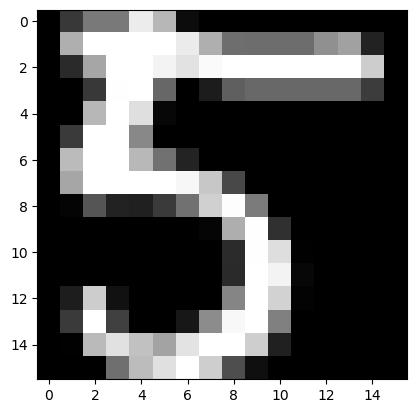

In [24]:
# Digit 5
n=9
I = np.reshape(train_5[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

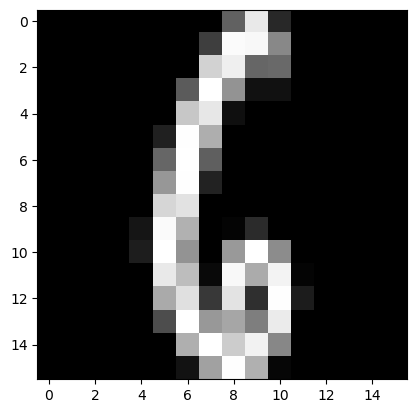

In [25]:
# Digit 6
n=5
I = reshape(train_6[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

The images we have are in 16x16 size which returns an extremely pixilated image. Ideally, working with a better quality image should help to get better results. However, by using compressed images, we greatly reduce the computation time of the algorithm, so if the algorithm performs well with compressed images, we should not deprive ourselves! 

### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:


In [26]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,1))   # label 1 for digit 6
class_train[:145] = 0       # label 0 for digit 5
class_train = np.squeeze(class_train)

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train
class_test = np.ones((875,1))
class_test[:(556-145)] = 0
class_test = np.squeeze(class_test)

## Exercise 2: logistic regression to classify 5 & 6

1. Note that pixel values are between -1 and 1 by using the functions
 `min(I(:))` and `max(I(:))`.
2. Identify the indices of the most significant pixels, which are defined 
as having a standard deviation greater than 0.5 here. We denote by `lis_sig`
the list of positions of these significant pixels in the image vector.
_Indication : the function `std` gives the standard deviation (columnwise
in matrices) and you should find 173 pixel positions.
3. Show a binary image to locate these pixels.
_Indication : `Isig = zeros(16); Isig(list_sig)=1; Isig=Isig';`._
4. Define the training set `x_train` from `x_train_brut` from the significant pixels only.
5. Do the same with `x_test_brut` to extract `x_test`.
6. Use `regression_logistique.m` to estimate the logistic regression vector
`w` from the training set `x_train`. 
Choose `Nitermax = 13; eps_conv = 1e-3;`
7. Compute the decision function and the labels of the test set `x_test`. 
_Indication : do not forget the column of ones !_
8. Estimate the classification error rate by using :
`erreur = sum(abs(class-class_test))/N_test;`.
9. Locate some misclassified examples and visualize the corresponding image.
Comment on your results and observations.


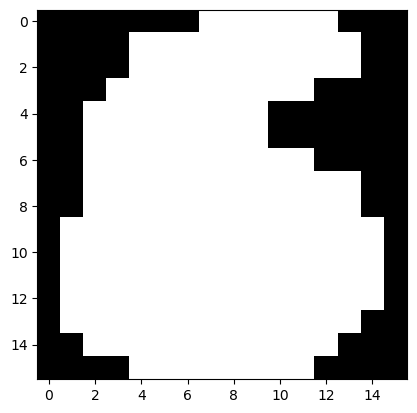

In [27]:
list_sig = np.where(np.std(x_train_brut, axis=0) > 0.5)[0].tolist()

Isig = np.zeros(256)
Isig[list_sig]=1
Isig = np.reshape(np.array(Isig), (16,16))
plt.imshow(Isig, cmap="gray")

In [28]:
x_train = x_train_brut[:, list_sig]
x_test = x_test_brut[:, list_sig]

In [30]:
try:
    w, Niter = regression_logistique(x_train, np.squeeze(class_train), Nitermax=13, eps_conv=1e-3)
except:
    print("Singular matrix")

Singular matrix


Unfortunately, we have problems with the inversion of the R matrix, so we need to find a way around this. 

Proposition 1 : Use of a constant in the matrix R to make it invertible

Proposition 2 : Stop the algorithm as soon as the matrix R is not invertible.

In [ ]:
from sklearn.metrics import confusion_matrix

class Logistique_Regression_early_stop():
    """This class implement the logistic regression using IRLS algorithm and an early stop if R matrix is not invertible.
    """
    def __init__(self, train:np.ndarray, class_train:np.ndarray, test:np.ndarray, class_test:np.ndarray, Nitermax:int = 13, eps_conv:float=1e-3):
        """
        Args:
            train (np.ndarray): training dataset 
            class_train (np.ndarray): respective class for the training dataset
            test (np.ndarray): test dataset 
            class_test (np.ndarray): respective class for the test dataset
            Nitermax (int, optional): The maximum number of iteration before the algorithm stop. Defaults to 13.
            eps_conv (float, optional): The tolerance criterion before the algorithm stop. Defaults to 1e-3.
        """
        self.train = train
        self.class_train = class_train
        self.N_train = train.shape[0]
        self.test = test
        self.class_test = class_test
        self.N_test = test.shape[0]
        self.Nitermax = Nitermax
        self.eps_conv = eps_conv
    
    def preprocessing(self, value:float=0.5):
        """Do the preprocessing of the images before the training

        Args:
            value (float, optional): The threshold used to select pixels. Defaults to 0.5.
        """
        lis_sig = np.where(np.std(self.train, axis=0) > value)[0].tolist()
        self.x_train = self.train[:, lis_sig]
        self.x_test = self.test[:, lis_sig]
        self.X_train = np.hstack((np.ones((self.N_train,1)),self.x_train))
        self.X_test = np.hstack((np.ones((self.N_test,1)),self.x_test))
    
    def fit(self):
        """Implementation of the IRLS algorithm method. If the matrix R is no longer invertible, the algorithm stop. Returns w and the number of iterations.
        """
        #initialisation : 1 pas de l'algorithme IRLS
        t = self.class_train
        X = self.X_train
        w = np.zeros((self.X_train.shape[1],))
        w_old = w 
        y = 1/2*np.ones((self.N_train,))
        R = np.diag(y*(1-y))   # diag(y_n(1-y_n))
        z = X.dot(w_old)-la.inv(R).dot(y-t)
        w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)

        # boucle appliquant l'algortihme de Newton-Raphson
        Niter = 1
        while ( (la.norm(w-w_old)/la.norm(w)>self.eps_conv) and (Niter<self.Nitermax) ):
            Niter = Niter+1
            y = 1/(1+np.exp(-X.dot(w)))
            R = np.diag(y*(1-y))  
            w_old = w 
            try:
                z = X.dot(w_old)-la.inv(R).dot(y-t) 
                w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
            except:
                break
        self.w = w
        self.Niter = Niter
    def predict(self):
        """Make predictions on the test dataset
        """
        predictions = lambda x: np.where(np.exp(x)/( 1 + np.exp(x))<=0.5, 0 , 1)
        self.t_test_pred = predictions(self.X_test @self.w)

    def confusion_matrix(self, show:bool=True)->np.ndarray:
        """Compute the confusion matrix

        Args:
            show (bool, optional): If true plot the confusion matrix. Defaults to True.

        Returns:
            np.ndarray: Confusion matrix as an array
        """
        cm = confusion_matrix(self.class_test, self.t_test_pred)
        if show:
            fig = px.imshow(cm, text_auto=True)
            fig.show()
        return cm

class Logistique_Regression_with_constant(Logistique_Regression_early_stop):
    def __init__(self, train:np.ndarray, class_train:np.ndarray, test:np.ndarray, class_test:np.ndarray, cst:float, Nitermax:int = 13, eps_conv:float=1e-3):
        """
        Args:
            train (np.ndarray): training dataset.
            class_train (np.ndarray): respective class for the training dataset.
            test (np.ndarray): test dataset.
            class_test (np.ndarray): respective class for the test dataset.
            cst (float): The value to add to the R matrix if it is not invertible.
            Nitermax (int, optional): The maximum number of iteration before the algorithm stop. Defaults to 13.
            eps_conv (float, optional): The tolerance criterion before the algorithm stop. Defaults to 1e-3.
        """
        super().__init__(train, class_train, test, class_test, Nitermax, eps_conv)
        self.cst = cst
    
    def fit(self):
        """Implementation of the IRLS algorithm method. If the matrix R is no longer invertible, we had the constant value cst to the R matrix before before computing the inverse. Returns w and the number of iterations.
        """
        #initialisation : 1 pas de l'algorithme IRLS
        t = self.class_train
        X = self.X_train
        w = np.zeros((self.X_train.shape[1],))
        w_old = w 
        y = 1/2*np.ones((self.N_train,))
        R = np.diag(y*(1-y))   # diag(y_n(1-y_n))
        z = X.dot(w_old)-la.inv(R).dot(y-t)
        w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)

        # boucle appliquant l'algortihme de Newton-Raphson
        Niter = 1
        while ( (la.norm(w-w_old)/la.norm(w)>self.eps_conv) and (Niter<self.Nitermax) ):
            Niter = Niter+1
            y = 1/(1+np.exp(-X.dot(w)))
            R = np.diag(y*(1-y))  
            w_old = w 
            try:
                z = X.dot(w_old)-la.inv(R).dot(y-t) 
            except:
                R = np.diag(y*(1-y) + self.cst)
                z = X.dot(w_old)-la.inv(R).dot(y-t) 
            w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
            
        self.w = w
        self.Niter = Niter

In [ ]:
rl_early_stop = Logistique_Regression_early_stop(x_train_brut, class_train,  x_test_brut, class_test)
rl_early_stop.preprocessing()
rl_early_stop.fit()
rl_early_stop.predict()

In [ ]:
rl_early_stop.Niter

We got Niter=Nitermax so we did not use the early stop.

In [ ]:
cm = rl_early_stop.confusion_matrix()

In [ ]:
rl_early_stop = Logistique_Regression_early_stop(x_train_brut, class_train,  x_test_brut, class_test, Nitermax=200)
rl_early_stop.preprocessing()
rl_early_stop.fit()
rl_early_stop.predict()

In [ ]:
rl_early_stop.Niter

Here we can see that there is an inversion problem at the 15th iteration !

In [ ]:
cm = rl_early_stop.confusion_matrix()

We get a better result, which makes sense since we did two more iterations.

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15, 15))

# Exemple 1
ax[0].set_title("Example 1")
ax[0].imshow(np.reshape(rl_early_stop.test[np.where(rl_early_stop.t_test_pred-rl_early_stop.class_test != 0)[0][0]], (16,16)))

# Exemple 2
ax[1].set_title("Example 2")
ax[1].imshow(np.reshape(rl_early_stop.test[np.where(rl_early_stop.t_test_pred-rl_early_stop.class_test != 0)[0][1]], (16,16)))

# Exemple 3
ax[2].set_title("Example 3")
ax[2].imshow(np.reshape(rl_early_stop.test[np.where(rl_early_stop.t_test_pred-rl_early_stop.class_test != 0)[0][-1]], (16,16)))

The first two examples have been classified as 6 instead of 5 and the last example has been classified as 5 instead of 6. We notice that for the first two examples, the high bar of the 5 extends a lot and thus a non-negligible number of important pixels of the image are not taken into account when passing from x_test_brut to x_test (i.e. after reduction of the dataset by calculating the sigma on pixels). Since only a small number of pixels are kept, it is understandable that the classification is more erroneous than in the case where more information is kept with the raw dataset. Let's check this:

In [ ]:
values = np.arange(0.01,0.901,0.01)
false_positive = np.zeros(values.shape[0])
false_negative = np.zeros(values.shape[0])
number_of_iterations = np.zeros(values.shape[0])
for i,value in enumerate(values):
    rl_early_stop = Logistique_Regression_early_stop(x_train_brut, class_train,  x_test_brut, class_test, Nitermax=200)
    rl_early_stop.preprocessing(value)
    rl_early_stop.fit()
    rl_early_stop.predict()
    cm = rl_early_stop.confusion_matrix(show=False)
    false_positive[i] = cm[0,1]
    false_negative[i] = cm[1,0]
    number_of_iterations[i] = rl_early_stop.Niter

df_analyse = pd.DataFrame({
    "Value for preprocessing": values,
    "Number of false positive": false_positive,
    "Number of false negative": false_negative,
    "Number of iterations": number_of_iterations  
})

px.line(df_analyse, "Value for preprocessing",y= ["Number of iterations", "Number of false positive", "Number of false negative"])

For our dataset, modifying the threshold for the pixels in the preprocessing allows to obtain better results. In any case, the estimator remains better with the 5 than with the 6 but changing the threshold to 0.52 allows to obtain optimal results on the test dataset.

By using the early stop method, we get good results. The estimator is however better at recognizing the 5 than the 6. We will compare this method to the added constant method.

In [ ]:
import seaborn as sns

cst_values = np.array([1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9,1e-8, 1e-7,  1e-6, 1e-5, 1e-4, 1e-3,1e-2, 1e-1])
false_positive = np.zeros(cst_values.shape[0])
false_negative = np.zeros(cst_values.shape[0])
number_of_iterations = np.zeros(cst_values.shape[0])
for i,cst in enumerate(cst_values):
    rl_cst = Logistique_Regression_with_constant(x_train_brut, class_train,  x_test_brut, class_test, cst=cst, Nitermax=200)
    rl_cst.preprocessing()
    rl_cst.fit()
    rl_cst.predict()
    cm = rl_cst.confusion_matrix(show=False)
    false_positive[i] = cm[0,1]
    false_negative[i] = cm[1,0]
    number_of_iterations[i] = rl_cst.Niter

df_analyse = pd.DataFrame({
    "Constant value": cst_values,
    "Number of false positive": false_positive,
    "Number of false negative": false_negative,
    "Number of iterations": number_of_iterations  
})

In [ ]:
px.line(df_analyse, "Constant value",y= ["Number of iterations", "Number of false positive", "Number of false negative"], log_x=True, title="Analysis as a function of the constant value")

[ You can click on Number of iterations to see only the variations of the number of false positives and false negatives ]

As we can see, the number of false positives and false negatives varies according to the value of the constant which shows that the value of the constant has a real impact on the training of the classifier. However, we manage to have a better result for a value of the constant equal to $10^{-7}$. However, the results remain similar and with the early stop technique the algorithm has a much shorter execution time.

In [ ]:

rl_cst.preprocessing()
rl_cst.fit()rl_cst = Logistique_Regression_with_constant(x_train_brut, class_train,  x_test_brut, class_test, cst=1e-7, Nitermax=200)
cm = rl_cst.confusion_matrix(on='test')

Another way to see how much of an impact adding this constant to the R matrix has is to look at the algorithm output w as a function of the constant.

In [ ]:
rl_cst_1 = Logistique_Regression_with_constant(x_train_brut, class_train,  x_test_brut, class_test, cst=1e-7, Nitermax=200)
rl_cst_1.preprocessing()
rl_cst_1.fit()
rl_cst_2 = Logistique_Regression_with_constant(x_train_brut, class_train,  x_test_brut, class_test, cst=1e-4, Nitermax=200)
rl_cst_2.preprocessing()
rl_cst_2.fit()

print("First values of w for cst=1e-7\n")
print(rl_cst_1.w[0:5],"\n")
print("First values of w for cst=1e-4\n")
print(rl_cst_2.w[0:5],"\n")

## 3. Logistic regression using `scikit-learn`

1. **Go to** http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for a presentation of the logistic regression model in `scikit-learn`.

2. **Apply** it to the present data set.

3. **Comment** on the use of logistic regression.

*Indication : you may have a look at* 

a) Theory : http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html

b) Video :  https://www.coursera.org/learn/machine-learning/lecture/4BHEy/regularized-logistic-regression 

c) Example : http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html#sphx-glr-auto-examples-exercises-plot-digits-classification-exercise-py

*for a short presentation of regularized logistic regression.*

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
# Training set
synth_train = np.loadtxt('synth_train.txt') 
class_train = synth_train[:,0]
class_train_1 = np.where(synth_train[:,0]==1)[0]
class_train_2 = np.where(synth_train[:,0]==2)[0]
x_train = synth_train[:,1:]
N_train = np.size(x_train,axis=0)

# Test set
synth_test = np.loadtxt('synth_test.txt')
class_test = synth_test[:,0]
class_test_1 = np.where(synth_test[:,0]==1)[0]
class_test_2 = np.where(synth_test[:,0]==2)[0]
x_test = synth_test[:,1:]
N_test = np.size(x_test,axis=0)

In [ ]:
clf = LogisticRegression(random_state=0, fit_intercept=True, tol=1e-3).fit(x_train, class_train)
w = clf.coef_[0]
bias = clf.intercept_[0]

In [ ]:
# print(f"Prédiction : {clf.predict(x_test)}")
print(f"Score : {clf.score(x_test, class_test)*100}%")
print(f"Coefficients de la régression : {bias, w}")

Using the scikit-learn regression method, we find a regression function of the form :

$y = 2.63*x[0] - 2.12*x[1] + 5.46$

In [ ]:
error_rate_train = 1 - clf.score(x_train, class_train)
error_rate_test = 1 - clf.score(x_test, class_test)

df_error_rate_comparison.loc['Logistic Regression with Sklearn'] = [error_rate_train, error_rate_test]

In [ ]:
df_error_rate_comparison

We obtain strange results on the error rate for the training dataset which does not seem to be better than the test one and which is worse than the one implemented at the beginning of the TP.

For this dataset, the algorithm converged before the max iteration number so assuming we have the same input parameters as for Sklearn, we should have the same results.

----------------------------------------------

For the dataset of the second exercise :

In [ ]:
lis_sig = np.where(np.std(x_train_brut, axis=0) > 0.5)[0].tolist()

x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,1))   # label 1 for digit 6
class_train[:145] = 0       # label 0 for digit 5
class_train = np.squeeze(class_train)

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train
class_test = np.ones((875,1))
class_test[:(556-145)] = 0
class_test = np.squeeze(class_test)

lis_sig = np.where(np.std(x_train_brut, axis=0) > 0.5)[0].tolist()

x_train = x_train_brut[:, lis_sig]
x_test = x_test_brut[:, lis_sig]


In [ ]:
clf = LogisticRegression(random_state=0, fit_intercept=True, tol=1e-3).fit(x_train_brut, class_train)
w = clf.coef_[0]
bias = clf.intercept_[0]

In [ ]:
# print(f"Prédiction : {clf.predict(x_test)}")
print(f"Score on brut dataset : {clf.score(x_test_brut, class_test)*100}%")
# print(f"Coefficients de la régression : {bias, w}")

In [ ]:
clf = LogisticRegression(random_state=0, fit_intercept=True,tol=1e-3).fit(x_train, class_train)
w = clf.coef_[0]
bias = clf.intercept_[0]

In [ ]:
# print(f"Prédiction : {clf.predict(x_test)}")
print(f"Score on dataset with lis_sig : {clf.score(x_test, class_test)*100}%")
# print(f"Coefficients de la régression : {bias, w}")

We note that keeping specific pixels based on the standard deviation increases the score of the prediction !

### Comparison with our implementation

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
plot_confusion_matrix(clf, x_test, class_test)

In [ ]:
clf = LogisticRegression(random_state=0,tol=1e-5, solver='liblinear').fit(x_train, class_train)
plot_confusion_matrix(clf, x_test, class_test)

We get much better results with the sklearn implementation. Moreover, depending on the solver used, the results are different. In the sklearn implementation, we can choose several logistic regression implementation methods that will not converge to the same solution, as we can see with the different confusion matrices above.

The algorithm seen in class for logistic regression is much less efficient than all the algorithms used by sklearn.

According to the Sklearn implementation, some methods are faster than other and more useful in some cases.

### Comparison of the execution time

In [ ]:
import timeit

rl_early_stop = Logistique_Regression_with_constant(x_train_brut, class_train,  x_test_brut, class_test, cst=1e-7, Nitermax=100)
rl_cst = Logistique_Regression_early_stop(x_train_brut, class_train,  x_test_brut, class_test, Nitermax=100)
rl_early_stop.preprocessing()
rl_cst.preprocessing()
loop = 10
execution_time_early_stop = timeit.timeit(lambda: rl_early_stop.fit(), number=loop) / loop
execution_time_cst= timeit.timeit(lambda: rl_cst.fit(), number=loop) / loop
execution_time_sklearn = timeit.timeit(lambda: LogisticRegression(random_state=0,tol=1e-3).fit(x_train, class_train), number=loop) / loop

print(f"The sklearn implementation is {int(execution_time_early_stop / execution_time_sklearn)} faster than our implementation with early stop.\nThe sklearn implementation is {int(execution_time_cst / execution_time_sklearn)} faster than our implementation with constant.")